# Setting Limits
1) Make cuts on $E_e$
2) Make cuts on background (1 shower, 0 tracks)
3) Make cuts on $\cos(\theta_\text{NuMI})$ for both
4) Set limits
    1) For the fixed $M_\chi/M_{A'}$ case
    2) For the fixed $M_\chi$ case
    

In [1]:
import os
import uproot3 as up3
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyhf
import sys
sys.path.append("../")
#from src import *
from src.data import load_root_file
from src.transforms import add_cos_theta_signal
from src.PoT_scalling import pot_scale
import src.constants as c

dm_types = ["scalar", "fermion"]
MICORBOONE_POT = c.POT_RUN1_MICROBOONE + c.POT_RUN3_MICROBOONE
CL = 0.1

In [2]:
# Cuts
E_e_min = 0.1 # GeV from ...
cos_theta_numi_cuts = [0.6, 0.8] # should probably study this AFTER E_e cut

In [3]:
def two_bin_hist(df : pd.DataFrame, pot_scale : float, cos_theta_numi_cuts : list):
    """Generate 2 bin histogram for the given data frame
    bin1 = cut gives background
    bin2 = cut gives signal

    Args:
        df (pandas.DataFrame): dataframe containing a column with "cos_theta_NuMI
        pot_scale (float): pmax * pot_run_1 / pot_sample
        cos_theta_numi_cuts (list): [cut lower, cut upper] (such that we get signal with these cuts)

    Returns:
        (np.array, np.array) : [counts background, counts signal], [bin edges]
    """
    

    hist = np.zeros(2)
    hist[0] = pot_scale * len(df[(df["cos_theta_numi"] < cos_theta_numi_cuts[0]) | (df["cos_theta_numi"] > cos_theta_numi_cuts[1])])
    hist[1] = pot_scale * len(df[(df["cos_theta_numi"] >= cos_theta_numi_cuts[0]) & (df["cos_theta_numi"] <= cos_theta_numi_cuts[1])])
    return hist, np.array([0,0.5,1])

### Backgrounds

In [4]:
CUT_SHOWERS = 1
CUT_TRACKS = 0

vars = ['reco_asso_showers', 'reco_asso_tracks', 'reco_shower_dirx', 'reco_shower_diry', 'reco_shower_dirz', 'reco_shower_energy_max']
bkg_path = "../data/root/background/"

def cuts(df : pd.DataFrame) -> pd.DataFrame:
    # for now, 0 tracks, 1 shower
    df = df[df['reco_asso_showers'] == CUT_SHOWERS]
    df = df[df['reco_asso_tracks'] == CUT_TRACKS]
    return df


bkg_incryo_df = pd.concat([load_root_file("run1_NuMI_nu_overlay_with_weights.root", bkg_path, vars, cuts, 10_000, 'vertex_tree;269'), 
                          load_root_file("run1_NuMI_nu_overlay_with_weights.root", bkg_path, vars, cuts, 10_000, 'vertex_tree;268')])
bkg_dirt_df = pd.concat([load_root_file("run1_NuMI_dirt_with_weights.root", bkg_path, vars, cuts, 10_000, 'vertex_tree;127'),
                        load_root_file("run1_NuMI_dirt_with_weights.root", bkg_path, vars, cuts, 10_000, 'vertex_tree;126')])
bkg_beamoff_df = load_root_file("run1_NuMI_offbeam_full_set_sp.root", bkg_path, vars, cuts, 10_000, "singlephotonana")

bkg_total = pd.concat([bkg_incryo_df, bkg_dirt_df, bkg_beamoff_df])
print(len(bkg_total))

/home/alex/projects/DarkElectronScatter/notebooks/../src/data.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat((df, df_temp))
/home/alex/projects/DarkElectronScatter/notebooks/../src/data.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat((df, df_temp))
/home/alex/projects/DarkElectronScatter/notebooks/../src/data.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer e

25623


In [5]:
# get the 2-bin histogram for the background
# pot_run1 / pot_file
bkg_pot_df = pd.DataFrame(columns=["bkg_type", "pot_ratio"])
bkg_pot_df.loc[0] = ["nu",(1/2.35e+21)*MICORBOONE_POT]
bkg_pot_df.loc[1] = ["dirt",(1/1.55e+21)*MICORBOONE_POT]
bkg_pot_df.loc[2] = ["offbeam",0.98*(5736147/9186361.390000)  * (MICORBOONE_POT / 2e20)]
bkg_hist_incryo, bkg_edges_incryo = two_bin_hist(bkg_incryo_df, bkg_pot_df[bkg_pot_df["bkg_type"]=="nu"]["pot_ratio"], cos_theta_numi_cuts)
bkg_hist_dirt, bkg_edges_dirt = two_bin_hist(bkg_dirt_df, bkg_pot_df[bkg_pot_df["bkg_type"]=="dirt"]["pot_ratio"], cos_theta_numi_cuts)
bkg_hist_beamoff, bkg_edges_beamoff = two_bin_hist(bkg_beamoff_df, bkg_pot_df[bkg_pot_df["bkg_type"]=="offbeam"]["pot_ratio"], cos_theta_numi_cuts)

bkg_hist_total = bkg_hist_incryo + bkg_hist_dirt + bkg_hist_beamoff
bkg_edges_total = bkg_edges_incryo

/tmp/ipykernel_796/3949741570.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hist[0] = pot_scale * len(df[(df["cos_theta_numi"] < cos_theta_numi_cuts[0]) | (df["cos_theta_numi"] > cos_theta_numi_cuts[1])])
/tmp/ipykernel_796/3949741570.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hist[1] = pot_scale * len(df[(df["cos_theta_numi"] >= cos_theta_numi_cuts[0]) & (df["cos_theta_numi"] <= cos_theta_numi_cuts[1])])


### Fixed $M_\chi/M_{A'}$

In [227]:
data_dir = "../data/root/BdNMC/"

n_evts_df = []
#costhetanumihist = np.zeros(50)
#bins = np.linspace(-1,1,51)

for dm_type in dm_types:
    for file in os.listdir(data_dir+dm_type+"/"):
        with up3.open(data_dir+dm_type+"/"+file) as f:
            if f.keys() == []:
                continue

            df = f["elecron_tree"].pandas.df()
            df = df[df["electron_energy"] >= 0.1] # Cut on Energy
            n_electrons = len(df)
            df = add_cos_theta_signal(df)
            #costhetanumihist += np.histogram(df["cos_theta_numi"], bins=bins)[0]
            pot = f["pot_tree"]["tot_pot"].array()
            pmax = f["pot_tree"]["pmax"].array()

            dt = file.split("_")[5].strip(".root")
            ma = file.split("_")[3]
            meson_t = file[0:3]

            pot_sc = (MICORBOONE_POT / pot) * pmax
            hist, edges = two_bin_hist(df, pot_sc, cos_theta_numi_cuts)
            n_evts_df.append([dm_type, dt, ma, meson_t, hist, edges])

n_evts_df = pd.DataFrame(n_evts_df, columns=["dm_type", "dt", "ma", "meson_t", "hist", "edges"])
#display(n_evts_df)


# Need to add pi0 and eta files together

get_other_meson_dict = {"pi0":"eta", "eta":"pi0"}

merged_df = pd.DataFrame(columns=["dm_type", "dt", "ma", "hist", "edges"])

i = 0
for signal in n_evts_df.iterrows():
    # okay so we cannot assume we always have a pi0 and eta file
    # so we need to check if the other file exists
    dt = signal[1]["dt"]
    ma = signal[1]["ma"]
    meson_t = signal[1]["meson_t"]
    dm_type = signal[1]["dm_type"]
    other_meson_t = get_other_meson_dict[meson_t]
    
    # look for the other meson in the n_evts_df, add it, and remove it
    other_meson = n_evts_df[(n_evts_df["meson_t"]==other_meson_t) & (n_evts_df["dm_type"]==dm_type) & (n_evts_df["dt"]==dt) & (n_evts_df["ma"]==ma)]
    if len(other_meson) == 0:
        # no matching meson found
        merged_df.loc[i] = signal[1]
        i += 1
    else:
        # add the two histograms together
        #print(signal[1]["hist"], other_meson["hist"].values[0], signal[1]["hist"] + other_meson["hist"].values[0])
        hist = signal[1]["hist"] + other_meson["hist"].values[0]
        edges = signal[1]["edges"]
        merged_df.loc[i] = [dm_type, dt, ma, hist, edges]
        n_evts_df.drop(other_meson.index, inplace=True) # to avoid duplicates in the merged_df
        i += 1

# plt.stairs(costhetanumihist, bins, fill=True, alpha=0.5, label="NuMI")
# plt.plot([cos_theta_numi_cuts[0], cos_theta_numi_cuts[0]], [0,10000], "r--", label="Signal region")
# plt.plot([cos_theta_numi_cuts[1], cos_theta_numi_cuts[1]], [0,10000], "r--")
# plt.xlabel("cos(theta)")
# plt.ylabel("Events")
# plt.title("cos(theta) distribution")
# plt.legend()
# plt.show()

/tmp/ipykernel_3785/3949741570.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist[0] = pot_scale * len(df[(df["cos_theta_numi"] < cos_theta_numi_cuts[0]) | (df["cos_theta_numi"] > cos_theta_numi_cuts[1])])
/tmp/ipykernel_3785/3949741570.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist[1] = pot_scale * len(df[(df["cos_theta_numi"] >= cos_theta_numi_cuts[0]) & (df["cos_theta_numi"] <= cos_theta_numi_cuts[1])])
/tmp/ipykernel_3785/3949741570.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing 

[  31.74403685 2761.73120588] [  1.72575698 269.21808921] [  33.46979383 3030.94929509]
[    0.         26631.15839491] [   0.         2657.73613868] [    0.         29288.89453359]
[  0.         116.22064265] [ 0.         30.83390175] [  0.        147.0545444]
[   0.        8157.2611966] [   5.47477792 1264.67369878] [5.47477792e+00 9.42193490e+03]
[ 0.25470638 58.07305421] [ 0.         13.20899062] [ 0.25470638 71.28204483]
[  0.         642.42715056] [   0.        4399.4313595] [   0.         5041.85851006]
[ 0.         13.20899062] [ 0.25470638 58.07305421] [ 0.25470638 71.28204483]
[0.         0.70884144] [0.        0.4684653] [0.         1.17730675]
[0.        0.4684653] [0.         0.70884144] [0.         1.17730675]
[0.         0.00111421] [0.         0.07153462] [0.         0.07264883]
[0.         0.14569046] [0.         0.01473686] [0.         0.16042732]
[   0.         7594.81138436] [  432.05267121 87706.69225606] [  432.05267121 95301.50364042]
[0.         0.07296901] [0. 

/tmp/ipykernel_3785/3949741570.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist[0] = pot_scale * len(df[(df["cos_theta_numi"] < cos_theta_numi_cuts[0]) | (df["cos_theta_numi"] > cos_theta_numi_cuts[1])])
/tmp/ipykernel_3785/3949741570.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist[1] = pot_scale * len(df[(df["cos_theta_numi"] >= cos_theta_numi_cuts[0]) & (df["cos_theta_numi"] <= cos_theta_numi_cuts[1])])
/tmp/ipykernel_3785/3949741570.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing 

In [73]:
plotting = False
for signal in merged_df.iterrows():
    dt = signal[1]["dt"]
    dm = signal[1]["dm_type"]
    ma = signal[1]["ma"]
    if plotting:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.stairs(bkg_hist_total, bkg_edges_total, label="Background", color="tab:red")
        ax.stairs(signal[1]["hist"], signal[1]["edges"], label="Signal", color="tab:blue")
        ax.legend()
        ax.set(title=r"$M_\chi/M_{A'}$="+signal[1]["dt"]+r" $M_{A'}="+signal[1]["ma"]+"$ GeV", xlabel=r"Signal Score", ylabel="Events")
        plt.savefig("../plots/signal_background_scores/fixed_dt/"+f"{dm}_ma_{ma}_dt_{dt}.png")
        plt.savefig("../plots/signal_background_scores/fixed_dt/"+f"{dm}_ma_{ma}_dt_{dt}.pdf")
        plt.show()
    
    # add the histograms to root files
    with uproot.recreate("../data/root/hist/fixed_dt/"+f"{dm}_ma_{ma}_dt_{dt}.root") as f:
        f["signal"] = signal[1]["hist"], signal[1]["edges"]
        f["background"] = bkg_hist_total, bkg_edges_total


In [74]:
f = uproot.open("../data/root/hist/fixed_dt/scalar_ma_0.04_dt_0.33.root")
s = f["signal"].values()
b = f["background"].values()
print(s, b)

[5.47477792e+00 9.42193490e+03] [15874.0117721   2212.31183635]


In [87]:
# set limits
def pyhf_limits(rootfname : str, rootfpath : str, nominal_eps : float = 1e-3, bkg_err : float = 0.1, CL=0.1):
    with uproot.open(rootfpath+rootfname+".root") as file:
        total_sig = np.sum(file["signal"].values())
        total_bkg = np.sum(file["background"].values())

        if total_sig == 0:
            print(f"No signal for {rootfpath+rootfname}")
            return 0, 0, 0, 0
        
        # if total_sig / total_bkg > 10:
        #     print("sig / bkg > 10 (crazy)")
        #     print(total_sig / total_bkg)

        if (total_bkg / total_sig > 10) or (total_sig / total_bkg > 15): # maybe make this > 5? ("buffer zone")
            # need to rescale it
            print(f"Rescaling for {rootfpath+rootfname}")
            

            # N_s ~ eps_nom^4
            # scale eps_nom^4
            ratio = (total_bkg/total_sig)

            # want total_sig = total_sig * ratio
            # so we want eps_nom^4 = eps_nom^4 * ratio?
            
            nominal_eps = (nominal_eps**4 * ratio)**(1/4)

            # do the pyhf analysis

            s = file["signal"].values()
            b = file["background"].values()

            s = s * ratio
            
            bkg_uncertainty = bkg_err * b
            model = pyhf.simplemodels.uncorrelated_background(signal=s, bkg=b, bkg_uncertainty=bkg_uncertainty)
            obs = list(b) + list(model.config.auxdata)


            poi_values = np.linspace(0., 10., 100)
            obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(obs, model, poi_values, level=CL, return_results=True)
            mu_obs, mu_exp = obs_limit, exp_limits[2]
            obs_epsilon = (nominal_eps**2)*np.sqrt(obs_limit)
            exp_epsilon = (nominal_eps**2)*np.sqrt(exp_limits[2])


        else:
            print(f"NOT Rescaling for {rootfpath+rootfname}")
            # do the pyhf analysis
            s = file["signal"].values()
            b = file["background"].values()

            
            bkg_uncertainty = bkg_err * b

            model = pyhf.simplemodels.uncorrelated_background(signal=s, bkg=b, bkg_uncertainty=bkg_uncertainty)

            obs = list(b) + list(model.config.auxdata)
            
            poi_values = np.linspace(0., 10., 100)
            obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(obs, model, poi_values, level=CL, return_results=True)
            mu_obs, mu_exp = obs_limit, exp_limits[2]
            obs_epsilon = (nominal_eps**2)*np.sqrt(obs_limit)
            exp_epsilon = (nominal_eps**2)*np.sqrt(exp_limits[2])
    

    return obs_epsilon, exp_epsilon, mu_obs, mu_exp

In [88]:
limits_df = []
for file in os.listdir("../data/root/hist/fixed_dt/"):
    if file.endswith(".root"):
        #print(file)
        obs_epsilon, exp_epsilon, mu_obs, mu_exp = pyhf_limits(file.strip(".root"), "../data/root/hist/fixed_dt/", CL=CL)
        #obs_epsilon, exp_epsilon, mu_obs, mu_exp = 0, 0, 0, 0
        # with uproot.open(f"../data/root/hist/fixed_dt/{file}") as f:
        #     if f["signal"].values()[0] == 0:
        #         print("0 bin",file)
        #     else:
        #         print("non-zero bin",file)
        
        # print(f"Observed epsilon: {obs_epsilon}")
        # print(f"Expected epsilon: {exp_epsilon}")
        # print(f"Observed mu: {mu_obs}")
        # print(f"Expected mu: {mu_exp}")
        # print("\n")
        ma = file.split("_")[2]
        dt = file.split("_")[4]
        dmt = file.split("_")[0]
        limits_df.append([dmt, ma, dt, obs_epsilon, exp_epsilon, mu_obs, mu_exp])

limits_df = pd.DataFrame(limits_df, columns=["dm_type", "ma", "dt", "obs_epsilon", "exp_epsilon", "mu_obs", "mu_exp"])


Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.08_dt_0.6


/home/alex/projects/DarkElectronScatter/venv/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Rescaling for ../data/root/hist/fixed_dt/fermion_ma_0.3_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/fermion_ma_0.1_dt_0.33
NOT Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.01_dt_0.6
No signal for ../data/root/hist/fixed_dt/fermion_ma_0.7_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.6_dt_0.33
NOT Rescaling for ../data/root/hist/fixed_dt/fermion_ma_0.06_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.02_dt_0.6
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.2_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/fermion_ma_0.2_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.08_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/fermion_ma_0.05_dt_0.6
NOT Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.03_dt_0.33
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.04_dt_0.6
Rescaling for ../data/root/hist/fixed_dt/scalar_ma_0.03_dt_0.6
No signal for ../data/root/hist/fixed_dt/fermion_ma_0.6_dt_0.33
Rescaling for ../data/root/hist/f

$$\Delta = \sqrt(2\sigma^2)\text{erf}^{-1}(2(CL-0.5)) $$
$$N_S(M_{A'}, \epsilon)\varepsilon_S(M_{A'})=\Delta\times\sqrt(\varepsilon_B)$$

$$ \varepsilon_S = 1-\beta = \text{ Signal Efficiency } = $$
$$ \varepsilon_B = \alpha $$
https://www.physi.uni-heidelberg.de/~reygers/lectures/2017/smipp/stat_methods_ss2017_06_hypothesis_testing.pdf 

In [1]:
from scipy.special import erfinv
N_B = bkg_hist_total[0]
sigma = np.sqrt(N_B)
Delta = np.sqrt(2*sigma**2) * erfinv(2*((1-CL)-0.5))
print(Delta)
def simple_counting_experiment(signal_hist, CL=0.9, epsilon=1e-3, alpha_D=0.1):
    # could try https://pyhf.github.io/tutorial-ATLAS-SUSY-Exotics-2020/SimpleModel.html too
    
    # N_B = total backgrounds
    N_B = bkg_hist_total[0] + bkg_hist_total[1]
    # N_S = total signal after cuts

    #print(N_B)
    
    # background selection efficiency
    eff_B = bkg_hist_total[1] / N_B

    #print(eff_B)

    # signal selection efficiency
    eff_S = 1 - signal_hist[0] / (signal_hist[0]+signal_hist[1])

    #print(eff_S)

    N_S = Delta * np.sqrt(eff_B) / eff_S

    #print(N_S)

    # N_S_exp = eps_exp**4 * alpha_D**2
    # eps_exp = N_S_exp**(1/4) / alpha_D**2
    eps_expected = N_S**(1/4) / alpha_D**2
    # but surely i need some factors of epsilon in here too?
    

    print(eps_expected)
    
    
    return eps_expected

NameError: name 'bkg_hist_total' is not defined

In [26]:
simple_conting_limits = []
for file in os.listdir("../data/root/hist/fixed_dt/"):
    if file.endswith(".root"):
        with uproot.open(f"../data/root/hist/fixed_dt/{file}") as f:
            signal = f["signal"].values()
            obs_epsilon = simple_counting_experiment(signal, CL=CL)
            ma = file.split("_")[2]
            dt = file.split("_")[4]
            dmt = file.split("_")[0]
            simple_conting_limits.append([dmt, float(ma), dt.strip(".root"), obs_epsilon])

simple_conting_limits = pd.DataFrame(simple_conting_limits, columns=["dm_type", "ma", "dt", "obs_epsilon"])
display(simple_conting_limits)

278.63765998659386
278.63765998659386
278.63765998659386
279.4037213956642
nan
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.8862355193962
nan
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.63765998659386
278.95292788568156
278.63765998659386
278.63765998659386
nan
278.63765998659386
27

/tmp/ipykernel_796/3017817834.py:21: RuntimeWarning: invalid value encountered in scalar divide
  eff_S = 1 - signal_hist[0] / (signal_hist[0]+signal_hist[1])


,dm_type,ma,dt,obs_epsilon
0,scalar,0.08,0.6,278.637660
1,fermion,0.30,0.33,278.637660
2,fermion,0.10,0.33,278.637660
3,scalar,0.01,0.6,279.403721
4,fermion,0.70,0.33,NaN
...,...,...,...,...
70,fermion,0.08,2.0,278.637660
71,scalar,0.01,2.0,278.637660
72,fermion,0.01,2.0,278.712342
73,scalar,0.09,0.33,278.637660


,Unnamed: 0,dm_type,ma,dt,obs_epsilon,exp_epsilon,mu_obs,mu_exp
0,0,scalar,0.08,0.6.root,1.012371e-04,1.012371e-04,0.090909,0.090909
1,1,fermion,0.30,0.33.root,2.441386e-04,2.441386e-04,0.090909,0.090909
2,2,fermion,0.10,0.33.root,2.786627e-06,2.786627e-06,0.090909,0.090909
3,3,scalar,0.01,0.6.root,3.720525e-07,3.720525e-07,0.138423,0.138423
4,4,fermion,0.70,0.33.root,0.000000e+00,0.000000e+00,0.000000,0.000000


/tmp/ipykernel_796/1125206230.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limits_df_loc["ma"] = limits_df_loc["ma"].apply(lambda x: float(x))


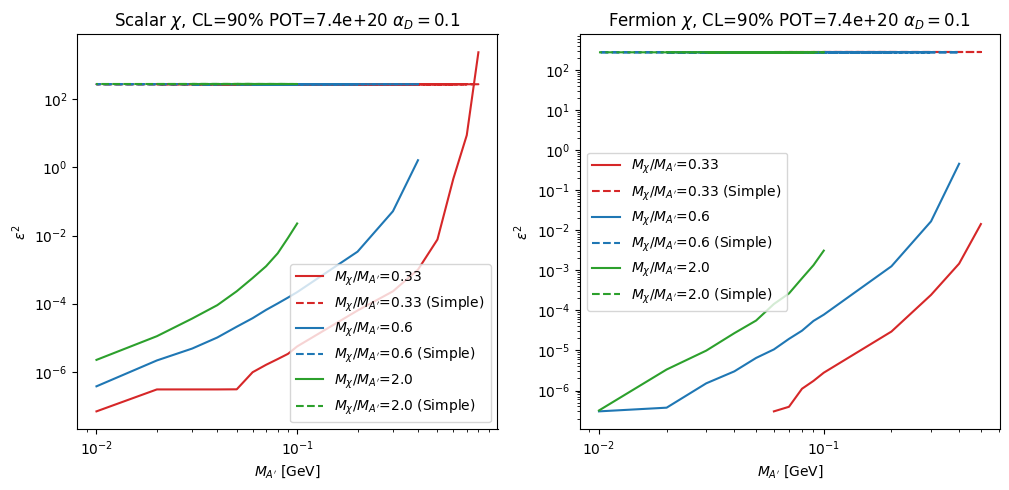

In [27]:
#limits_df = pd.DataFrame(limits_df, columns=["dm_type", "ma", "dt", "obs_epsilon", "exp_epsilon", "mu_obs", "mu_exp"])
#limits_df.to_csv("../data/csv/fixed_dt.csv")
limits_df = pd.read_csv("../data/csv/fixed_dt.csv")
display(limits_df.head())

# Plot limits


#display(limits_df)

cols = {"0.33":"tab:red", "0.6":"tab:blue", "2.0":"tab:green"}
fig = plt.figure(figsize=(10.2,5))
ax = fig.subplots(1,2)


for i, dm_type in enumerate(["scalar", "fermion"]):
    
    for dt in ["0.33", "0.6", "2.0"]:
        limits_df_loc = limits_df[(limits_df["dt"]==dt+".root") & (limits_df["dm_type"] == dm_type)]
        simple_conting_limits_loc = simple_conting_limits[(simple_conting_limits["dt"]==dt) & (simple_conting_limits["dm_type"] == dm_type)]

        limits_df_loc["ma"] = limits_df_loc["ma"].apply(lambda x: float(x))
        limits_df_loc = limits_df_loc[limits_df_loc["obs_epsilon"] > 0]
        limits_df_loc.sort_values(by="ma", inplace=True)
        #display(limits_df_loc)
        ax[i].plot(limits_df_loc["ma"], limits_df_loc["obs_epsilon"], label=r"$M_\chi/M_{A'}$"+f"={dt}", color=cols[dt])
        ax[i].plot(simple_conting_limits_loc["ma"], simple_conting_limits_loc["obs_epsilon"], label=r"$M_\chi/M_{A'}$"+f"={dt} (Simple)", color=cols[dt], linestyle="--")
        #ax.scatter(limits_df_loc["ma"], limits_df_loc["exp_epsilon"], label=f"Expected, dt={dt}", color=cols[dt])
        

    #ax_scalar.legend()
    ax[i].set(title=f"{dm_type}".capitalize() + rf" $\chi$, CL={1-CL:.0%} POT={MICORBOONE_POT} "+r"$\alpha_D=0.1$",
              xlabel=r"$M_{A'}$ [GeV]", ylabel=r"$\epsilon^2$")
    ax[i].loglog()
    ax[i].legend()

fig.tight_layout()
#plt.savefig("../plots/limits/fixed_dt/bare_limits.png")
#plt.savefig("../plots/limits/fixed_dt/bare_limits.pdf")
plt.show()


/tmp/ipykernel_3785/1229712922.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limits_df_loc["ma"] = limits_df_loc["ma"].apply(lambda x: float(x))
/tmp/ipykernel_3785/1229712922.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limits_df_loc["ma"] = limits_df_loc["ma"].apply(lambda x: float(x))


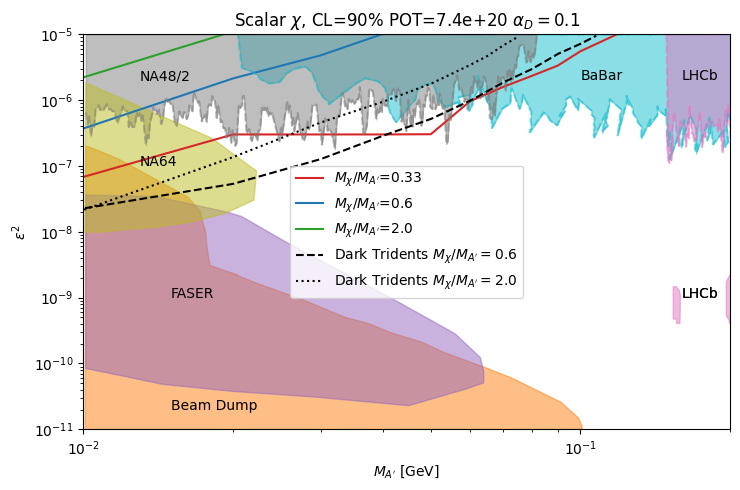

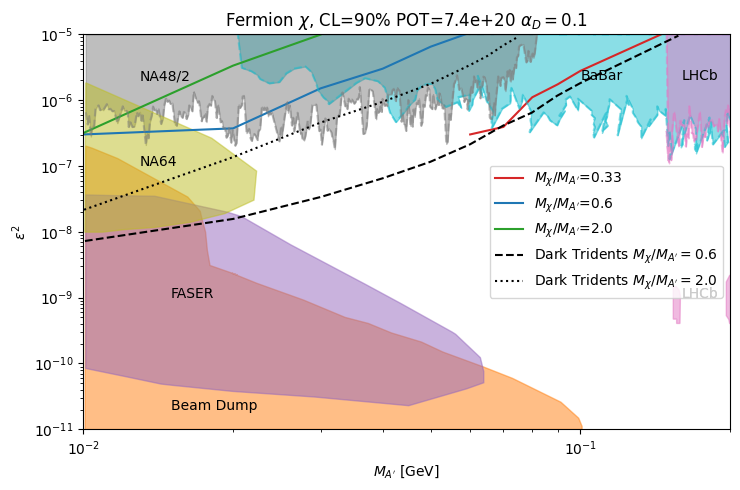

In [197]:
#Luis_scalar_06 = pd.read_csv("../data/csv/Scalar-dt06.csv", names=["ma", "obs_epsilon"])
#Luis_fermion_06 = pd.read_csv("../data/csv/Fermion-dt06.csv", names=["ma", "obs_epsilon"])
#Luis_scalar_20 = pd.read_csv("../data/csv/Scalar-dt20.csv", names=["ma", "obs_epsilon"])
#Luis_fermion_20 = pd.read_csv("../data/csv/Fermion-dt20.csv", names=["ma", "obs_epsilon"])
#display(Luis_scalar_06)

lims_BaBar = pd.read_csv("../data/csv/BaBar.csv", names=["ma", "obs_epsilon"])
lims_Beam_Dump = pd.read_csv("../data/csv/Beam Dump.csv", names=["ma", "obs_epsilon"])
lims_FASER = pd.read_csv("../data/csv/FASER.csv", names=["ma", "obs_epsilon"])
lims_LHCb = pd.read_csv("../data/csv/LHCb.csv", names=["ma", "obs_epsilon"])
lims_LHCb2 = pd.read_csv("../data/csv/LHCb2.csv", names=["ma", "obs_epsilon"])
lims_LHCb3 = pd.read_csv("../data/csv/LHCb3.csv", names=["ma", "obs_epsilon"])
lims_NA48_2 = pd.read_csv("../data/csv/NA48_2.csv", names=["ma", "obs_epsilon"])
lims_NA64 = pd.read_csv("../data/csv/NA64.csv", names=["ma", "obs_epsilon"])



#display(lims_Beam_Dump)

other_lims = {"BaBar":lims_BaBar, "Beam Dump":lims_Beam_Dump, "FASER":lims_FASER, "LHCb":lims_LHCb, "LHCb2":lims_LHCb2, "LHCb3":lims_LHCb3, "NA48/2":lims_NA48_2, "NA64":lims_NA64}
# subtract 0.1e-2 from all MA values
for key in other_lims.keys():
    other_lims[key]["ma"] = other_lims[key]["ma"].apply(lambda x: float(x) - 0.1e-2)

fill_above = ["NA48/2", "BaBar", "LHCb"]
fill_other = ["FASER", "NA64", "LHCb2", "LHCb3", "Beam Dump"]
colours = {"BaBar":"tab:cyan", "Beam Dump":"tab:orange", "FASER":"tab:purple", "LHCb":"tab:pink", "LHCb2":"tab:pink", "LHCb3":"tab:pink", "NA48/2":"tab:gray", "NA64":"tab:olive"}
locs = {"BaBar":(1e-1, 2e-6), "LHCb":(1.6e-1, 2e-6), "NA48/2":(1.3e-2, 2e-6), "NA64":(1.3e-2, 1e-7), "FASER": (1.5e-2,1e-9), "Beam Dump":(1.5e-2,2e-11), "LHCb2":(1.6e-1,1e-9), "LHCb3":(1.6e-1,1e-9)}

Luis_scalar_06 = pd.read_csv("../data/csv/Scalar_0.6.csv", names=["ma", "obs_epsilon"])
Luis_fermion_06 = pd.read_csv("../data/csv/Fermion_0.6.csv", names=["ma", "obs_epsilon"])
Luis_scalar_20 = pd.read_csv("../data/csv/Scalar_2.0.csv", names=["ma", "obs_epsilon"])
Luis_fermion_20 = pd.read_csv("../data/csv/Fermion_2.0.csv", names=["ma", "obs_epsilon"])


# Plot limits
limits_df.to_csv("../data/csv/fixed_dt.csv")

#display(limits_df)

cols = {"0.33":"tab:red", "0.6":"tab:blue", "2.0":"tab:green"}


for dm_type in ["scalar", "fermion"]:
    fig = plt.figure(figsize=(7.5,5))
    ax = fig.add_subplot(111)
    ax.set_ylim(1e-11, 1e-5)
    ax.set_xlim(1e-2, 2e-1)
    for dt in ["0.33", "0.6", "2.0"]:
        limits_df_loc = limits_df[(limits_df["dt"]==dt+".root") & (limits_df["dm_type"] == dm_type)]

        limits_df_loc["ma"] = limits_df_loc["ma"].apply(lambda x: float(x))
        limits_df_loc = limits_df_loc[limits_df_loc["obs_epsilon"] > 0]
        limits_df_loc.sort_values(by="ma", inplace=True)
        #display(limits_df_loc)
        ax.plot(limits_df_loc["ma"], limits_df_loc["obs_epsilon"], label=r"$M_\chi/M_{A'}$"+f"={dt}", color=cols[dt])
        #ax.scatter(limits_df_loc["ma"], limits_df_loc["exp_epsilon"], label=f"Expected, dt={dt}", color=cols[dt])

    for key in other_lims.keys():
        lim = other_lims[key]
        lim["ma"] = lim["ma"].apply(lambda x: float(x))
        #lim.sort_values(by="ma", inplace=True)
        
        # have the legend Label on the line
        if key not in ["LHCb2", "LHCb3"]:
            ax.text(locs[key][0], locs[key][1], str(key))
        else:
            ax.text(locs[key][0], locs[key][1], "LHCb")
        
        if key in fill_above:
            ax.plot(lim["ma"], lim["obs_epsilon"], linestyle="--", alpha=0.5, color=colours[key])
            ax.fill_between(lim["ma"], lim["obs_epsilon"], 1e-5, alpha=0.5, color=colours[key])
        
        if key in fill_other:
            ax.fill(lim["ma"], lim["obs_epsilon"], alpha=0.5, color=colours[key])


        


    
    if dm_type == "scalar":
        ax.plot(Luis_scalar_06["ma"], Luis_scalar_06["obs_epsilon"], label=r"Dark Tridents $M_\chi/M_{A'}=$0.6", color="black", linestyle="--")
        ax.plot(Luis_fermion_20["ma"], Luis_fermion_20["obs_epsilon"], label=r"Dark Tridents $M_\chi/M_{A'}=$2.0", color="black", linestyle="dotted")
    else:
        ax.plot(Luis_fermion_06["ma"], Luis_fermion_06["obs_epsilon"], label=r"Dark Tridents $M_\chi/M_{A'}=$0.6", color="black", linestyle="--")
        ax.plot(Luis_fermion_20["ma"], Luis_fermion_20["obs_epsilon"], label=r"Dark Tridents $M_\chi/M_{A'}=$2.0", color="black", linestyle="dotted")
    

    #ax_scalar.legend()
    ax.set(title=f"{dm_type}".capitalize() + rf" $\chi$, CL={1-CL:.0%} POT={MICORBOONE_POT} "+r"$\alpha_D=0.1$", xlabel=r"$M_{A'}$ [GeV]", ylabel=r"$\epsilon^2$")
    
    ax.loglog()
    # move the legend off the graph to the right
    # remove "LHCb2, LHCb3" from the legend
    
    ax.legend()
    fig.tight_layout()
    plt.savefig(f"../plots/limits/fixed_dt/Full_lims_{dm_type}.png")
    plt.savefig(f"../plots/limits/fixed_dt/Full_lims_{dm_type}.pdf")
    
    

plt.show()

/tmp/ipykernel_3785/666699720.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limits_df_loc["ma"] = limits_df_loc["ma"].apply(lambda x: float(x))


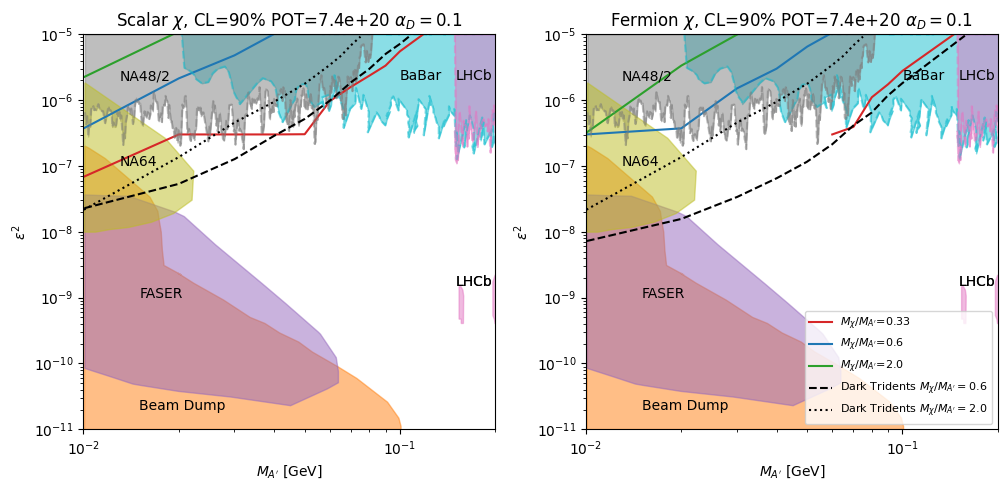

In [231]:
#Luis_scalar_06 = pd.read_csv("../data/csv/Scalar-dt06.csv", names=["ma", "obs_epsilon"])
#Luis_fermion_06 = pd.read_csv("../data/csv/Fermion-dt06.csv", names=["ma", "obs_epsilon"])
#Luis_scalar_20 = pd.read_csv("../data/csv/Scalar-dt20.csv", names=["ma", "obs_epsilon"])
#Luis_fermion_20 = pd.read_csv("../data/csv/Fermion-dt20.csv", names=["ma", "obs_epsilon"])
#display(Luis_scalar_06)

lims_BaBar = pd.read_csv("../data/csv/BaBar.csv", names=["ma", "obs_epsilon"])
lims_Beam_Dump = pd.read_csv("../data/csv/Beam Dump.csv", names=["ma", "obs_epsilon"])
lims_FASER = pd.read_csv("../data/csv/FASER.csv", names=["ma", "obs_epsilon"])
lims_LHCb = pd.read_csv("../data/csv/LHCb.csv", names=["ma", "obs_epsilon"])
lims_LHCb2 = pd.read_csv("../data/csv/LHCb2.csv", names=["ma", "obs_epsilon"])
lims_LHCb3 = pd.read_csv("../data/csv/LHCb3.csv", names=["ma", "obs_epsilon"])
lims_NA48_2 = pd.read_csv("../data/csv/NA48_2.csv", names=["ma", "obs_epsilon"])
lims_NA64 = pd.read_csv("../data/csv/NA64.csv", names=["ma", "obs_epsilon"])



#display(lims_Beam_Dump)

other_lims = {"BaBar":lims_BaBar, "Beam Dump":lims_Beam_Dump, "FASER":lims_FASER, "LHCb":lims_LHCb, "LHCb2":lims_LHCb2, "LHCb3":lims_LHCb3, "NA48/2":lims_NA48_2, "NA64":lims_NA64}
# subtract 0.1e-2 from all MA values
for key in other_lims.keys():
    other_lims[key]["ma"] = other_lims[key]["ma"].apply(lambda x: float(x) - 0.1e-2)

fill_above = ["NA48/2", "BaBar", "LHCb"]
fill_other = ["FASER", "NA64", "LHCb2", "LHCb3", "Beam Dump"]
colours = {"BaBar":"tab:cyan", "Beam Dump":"tab:orange", "FASER":"tab:purple", "LHCb":"tab:pink", "LHCb2":"tab:pink", "LHCb3":"tab:pink", "NA48/2":"tab:gray", "NA64":"tab:olive"}
locs = {"BaBar":(1e-1, 2e-6), "LHCb":(1.5e-1, 2e-6), "NA48/2":(1.3e-2, 2e-6), "NA64":(1.3e-2, 1e-7), "FASER": (1.5e-2,1e-9), "Beam Dump":(1.5e-2,2e-11), "LHCb2":(1.5e-1,1.5e-9), "LHCb3":(1.5e-1,1.5e-9)}

Luis_scalar_06 = pd.read_csv("../data/csv/Scalar_0.6.csv", names=["ma", "obs_epsilon"])
Luis_fermion_06 = pd.read_csv("../data/csv/Fermion_0.6.csv", names=["ma", "obs_epsilon"])
Luis_scalar_20 = pd.read_csv("../data/csv/Scalar_2.0.csv", names=["ma", "obs_epsilon"])
Luis_fermion_20 = pd.read_csv("../data/csv/Fermion_2.0.csv", names=["ma", "obs_epsilon"])


# Plot limits
limits_df.to_csv("../data/csv/fixed_dt.csv")

#display(limits_df)

cols = {"0.33":"tab:red", "0.6":"tab:blue", "2.0":"tab:green"}

fig = plt.figure(figsize=(10.2,5))
ax = fig.subplots(1,2)
i = 0
for dm_type in ["scalar", "fermion"]:
    
    
    ax[i].set_ylim(1e-11, 1e-5)
    ax[i].set_xlim(1e-2, 2e-1)
    for dt in ["0.33", "0.6", "2.0"]:
        limits_df_loc = limits_df[(limits_df["dt"]==dt+".root") & (limits_df["dm_type"] == dm_type)]

        limits_df_loc["ma"] = limits_df_loc["ma"].apply(lambda x: float(x))
        limits_df_loc = limits_df_loc[limits_df_loc["obs_epsilon"] > 0]
        limits_df_loc.sort_values(by="ma", inplace=True)
        #display(limits_df_loc)
        ax[i].plot(limits_df_loc["ma"], limits_df_loc["obs_epsilon"], label=r"$M_\chi/M_{A'}$"+f"={dt}", color=cols[dt])
        #ax.scatter(limits_df_loc["ma"], limits_df_loc["exp_epsilon"], label=f"Expected, dt={dt}", color=cols[dt])

    for key in other_lims.keys():
        lim = other_lims[key]
        lim["ma"] = lim["ma"].apply(lambda x: float(x))
        #lim.sort_values(by="ma", inplace=True)
        
        # have the legend Label on the line
        if key not in ["LHCb2", "LHCb3"]:
            ax[i].text(locs[key][0], locs[key][1], str(key))
        else:
            ax[i].text(locs[key][0], locs[key][1], "LHCb")
        
        if key in fill_above:
            ax[i].plot(lim["ma"], lim["obs_epsilon"], linestyle="--", alpha=0.5, color=colours[key])
            ax[i].fill_between(lim["ma"], lim["obs_epsilon"], 1e-5, alpha=0.5, color=colours[key])
        
        if key in fill_other:
            ax[i].fill(lim["ma"], lim["obs_epsilon"], alpha=0.5, color=colours[key])


        


    
    if dm_type == "scalar":
        ax[i].plot(Luis_scalar_06["ma"], Luis_scalar_06["obs_epsilon"], label=r"Dark Tridents $M_\chi/M_{A'}=$0.6", color="black", linestyle="--")
        ax[i].plot(Luis_fermion_20["ma"], Luis_fermion_20["obs_epsilon"], label=r"Dark Tridents $M_\chi/M_{A'}=$2.0", color="black", linestyle="dotted")
    else:
        ax[i].plot(Luis_fermion_06["ma"], Luis_fermion_06["obs_epsilon"], label=r"Dark Tridents $M_\chi/M_{A'}=$0.6", color="black", linestyle="--")
        ax[i].plot(Luis_fermion_20["ma"], Luis_fermion_20["obs_epsilon"], label=r"Dark Tridents $M_\chi/M_{A'}=$2.0", color="black", linestyle="dotted")
    

    #ax_scalar.legend()
    ax[i].set(title=f"{dm_type}".capitalize() + rf" $\chi$, CL={1-CL:.0%} POT={MICORBOONE_POT} "+r"$\alpha_D=0.1$", xlabel=r"$M_{A'}$ [GeV]", ylabel=r"$\epsilon^2$")
    
    ax[i].loglog()
    # move the legend off the graph to the right
    # remove "LHCb2, LHCb3" from the legend
    
    if i == 1:
        ax[i].legend(loc="lower right", fontsize=8)
    i = i + 1



fig.tight_layout()
plt.savefig(f"../plots/limits/fixed_dt/Full_lims.png")
plt.savefig(f"../plots/limits/fixed_dt/Full_lims.pdf")
    
    

plt.show()

### Fixed $M_\chi$
1) Read the .out files to check for line "in Off-Shell mode" or "in On-Shell mode"
2) for now, ignore "on shell" files (we dont know that they are handelled correctly)
3) Set Limits

In [58]:
# Get list of data files
data_dir = "../data/root/BdNMC/fixed_mchi/"
fnames = []
for dmt in dm_types:
    for file in os.listdir(data_dir+"/"+dmt+"/"):
        if file.endswith(".root"):
            meson = file.split("_")[0]
            ma = file.split("_")[3]
            mchi = file.split("_")[5]
            fnames.append((dmt, meson, ma, mchi, file, True))

fnames = pd.DataFrame(fnames, columns=["dm_type", "meson", "ma", "mchi", "file", "Off Shell"])

# go through the .out files
# e.g nodefixed_Mchi__pi0_scalar_ma_0.09_mchi_0.001.out
out_path = "../data/condor_out/fixed_mchi/"
for row in fnames.iterrows():
    file = row[1]["file"].strip(".root") + ".out"
    try:
        with open(out_path+"nodefixed_Mchi__"+file) as f:
            for line in f:
                if "Off-Shell" in line:
                    continue
                    #print(line)
                    # FINISH THIS!
                elif "On-Shell" in line:
                    ##print(file, line)
                    fnames.iloc[row[0]] = (row[1]["dm_type"], row[1]["meson"], row[1]["ma"], row[1]["mchi"], row[1]["file"], False)
                    #fnames.loc["Off Shell", row[0]] = False
    except:
        print("File not found", file)
        #fnames.loc["Off Shell", row[0]] = "N/A"
        fnames.iloc[row[0]] = (row[1]["dm_type"], row[1]["meson"], row[1]["ma"], row[1]["mchi"], row[1]["file"], "N/A")


File not found eta_fermion_ma_0.03_mchi_0.001.out
File not found eta_fermion_ma_0.08_mchi_0.001.out
File not found eta_fermion_ma_0.09_mchi_0.04.out
File not found pi0_fermion_ma_0.01_mchi_0.001.out
File not found eta_fermion_ma_0.02_mchi_0.001.out
File not found eta_fermion_ma_0.05_mchi_0.02.out
File not found eta_fermion_ma_0.07_mchi_0.001.out
File not found eta_fermion_ma_0.01_mchi_0.001.out
File not found pi0_fermion_ma_0.03_mchi_0.001.out
File not found eta_fermion_ma_0.1_mchi_0.001.out
File not found eta_fermion_ma_0.1_mchi_0.04.out
File not found eta_fermion_ma_0.09_mchi_0.001.out
File not found eta_fermion_ma_0.1_mchi_0.02.out
File not found eta_fermion_ma_0.07_mchi_0.02.out
File not found eta_fermion_ma_0.09_mchi_0.02.out
File not found eta_fermion_ma_0.08_mchi_0.02.out
File not found eta_fermion_ma_0.06_mchi_0.001.out
File not found eta_fermion_ma_0.04_mchi_0.001.out
File not found eta_fermion_ma_0.06_mchi_0.02.out
File not found pi0_fermion_ma_0.05_mchi_0.02.out
File not fou

/tmp/ipykernel_3785/1564697599.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  fnames.iloc[row[0]] = (row[1]["dm_type"], row[1]["meson"], row[1]["ma"], row[1]["mchi"], row[1]["file"], "N/A")


In [65]:
display(fnames[fnames["Off Shell"]==True])
print(len(fnames))
# not working :(

,dm_type,meson,ma,mchi,file,Off Shell
2,scalar,pi0,0.06,0.04.root,pi0_scalar_ma_0.06_mchi_0.04.root,True
3,scalar,eta,0.05,0.04.root,eta_scalar_ma_0.05_mchi_0.04.root,True
5,scalar,pi0,0.02,0.02.root,pi0_scalar_ma_0.02_mchi_0.02.root,True
6,scalar,eta,0.03,0.02.root,eta_scalar_ma_0.03_mchi_0.02.root,True
9,scalar,eta,0.02,0.02.root,eta_scalar_ma_0.02_mchi_0.02.root,True
...,...,...,...,...,...,...
128,fermion,eta,0.3,0.02.root,eta_fermion_ma_0.3_mchi_0.02.root,True
130,fermion,pi0,0.04,0.001.root,pi0_fermion_ma_0.04_mchi_0.001.root,True
131,fermion,pi0,0.06,0.001.root,pi0_fermion_ma_0.06_mchi_0.001.root,True
132,fermion,pi0,0.03,0.02.root,pi0_fermion_ma_0.03_mchi_0.02.root,True


136
